In [1]:
import pandas as pd
import numpy as np
import re
from keras.datasets import imdb

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from scipy import stats
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN,Dense,Activation,Input,LSTM

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay)

#path = "/content/drive/MyDrive/ML_Hillel/HW_L13_work_with_text/IMDB Dataset/"

In [2]:
#Завантаження датасету через вбудовану функцію imdb.load_data
#Параметри: num_words=15000 - беремо  для аналізу 15000 слів, що найчастіше вживаються

(X_train,Y_train),(X_test,Y_test) = imdb.load_data(path="imdb.npz",num_words=15000,skip_top=0,maxlen=None,start_char=1,seed=13,oov_char=2,index_from=3)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Перегляд вигляду імпортованих даних
X_train[:3]

array([list([1, 608, 13, 6467, 14, 22, 13, 80, 1109, 14, 20, 584, 18, 231, 72, 141, 6, 783, 254, 189, 7060, 13, 100, 115, 106, 14, 20, 584, 207, 82, 557, 111, 111, 537, 7, 4, 962, 12, 69, 11, 45, 204, 766, 33, 4, 8334, 23, 94, 797, 1048, 991, 527, 1987, 538, 2629, 4, 4518, 125, 72, 449, 8295, 68, 3385, 2500, 93, 14, 1190, 22, 13, 119, 12, 13, 197, 4, 226, 22, 16, 542, 5, 221, 14, 20, 9, 38, 629, 14, 9, 4, 6128, 20, 13, 28, 126, 110, 11, 61, 113, 24, 15, 51, 571, 11, 4, 22, 5, 4, 326, 7, 4, 22, 26, 24, 629, 195, 21, 51, 210, 188, 72, 16, 2, 2726, 116, 118, 189, 22, 126, 164, 70, 126, 30, 14, 629, 174, 2195, 829, 33, 94, 2]),
       list([1, 1751, 5594, 486, 9, 984, 11, 1058, 2, 4, 116, 5, 65, 26, 389, 48, 25, 70, 2879, 4, 1120, 148, 19, 815, 2, 80, 28, 49, 5654, 237, 4, 6478, 26, 821, 195, 8, 1203, 2, 7, 53, 74, 6, 171, 11, 4, 311, 10, 10, 827, 2, 5, 2, 1868, 2, 3846, 4, 7603, 21, 4, 185, 2, 2, 100, 79, 49, 622, 58, 23, 268, 120, 4, 375, 171, 153, 10, 10, 717, 2, 47, 1391, 39, 6, 1036, 

In [4]:
Y_train[:3]

array([0, 1, 1])

Отже, X - є типом 'numpy.ndarray', який складається із списків послідовностей чисел, де кожне число відповідає індексу слова зі словника IMDb, а Y - списки чисел 0 або 1, які є мітками для відповідних рецензій:
*   0: негативний відгук.
*   1: позитивний відгук





In [5]:
print("Y train values: ",np.unique(Y_train))
print("Y test values: ",np.unique(Y_test))

Y train values:  [0 1]
Y test values:  [0 1]


Перевірка збалансованості таргету

In [6]:
unique,counts = np.unique(Y_train,return_counts=True)
print("Y train distribution: ", dict(zip(unique,counts)))

unique,counts = np.unique(Y_test,return_counts=True)
print("Y test distribution: ", dict(zip(unique,counts)))

Y train distribution:  {0: 12500, 1: 12500}
Y test distribution:  {0: 12500, 1: 12500}


Бачимо, що таргет максимально збалансований

Для майбутнього вирівнювання послідовностей нам потрібно оцінити їх розподіл в датасеті

In [7]:
#Формування даних про довжини послідовностей, оцінки довжин зверху і знизу, та визначення середніх довжин
review_len_train = []
review_len_test = []
for i,j in zip(X_train,X_test):
    review_len_train.append(len(i))
    review_len_test.append(len(j))

print("min len train:", min(review_len_train), "\nmax len train:", max(review_len_train))
print("min len test:", min(review_len_test), "\nmax len test:", max(review_len_test))
print("average len train:", sum(review_len_train) / len(review_len_train))
print("average len test:", sum(review_len_test) / len(review_len_test))
print("Train mean: ", np.mean(review_len_train))
print("Test mean: ", np.mean(review_len_test))
print("Train median: ",np.median(review_len_train))
print("Test median: ",np.median(review_len_test))
print("Train mode: ",stats.mode(review_len_train))
print("Test mode: ",stats.mode(review_len_test))

min len train: 11 
max len train: 2494
min len test: 7 
max len test: 2315
average len train: 238.71364
average len test: 230.8042
Train mean:  238.71364
Test mean:  230.8042
Train median:  178.0
Test median:  174.0
Train mode:  ModeResult(mode=132, count=196)
Test mode:  ModeResult(mode=125, count=184)


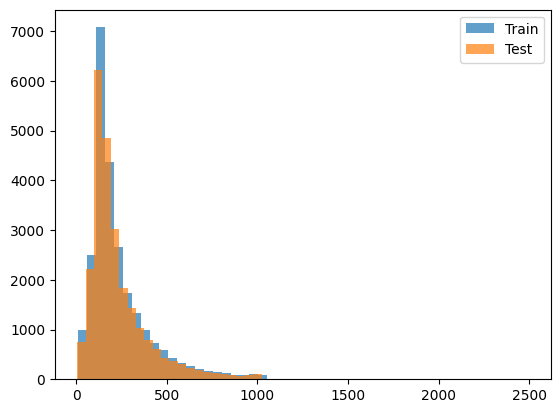

In [8]:
# Візуалізація розподілу довжин
plt.hist(review_len_train, bins=50, alpha=0.7, label="Train")
plt.hist(review_len_test, bins=50, alpha=0.7, label="Test")
plt.legend()
plt.show()

In [9]:
#Знайдемо кількість унікальних слів у загальному словнику
print(len(imdb.get_word_index()))

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
88584


Визначимо довжини послідовностей як 75% (Q3) всіх довжин послідовностей

In [10]:
# Обчислення відсотка покриття для різних maxlen
percentiles = [50, 75, 90, 95]
for p in percentiles:
    print(f"{p}-й перцентиль: {np.percentile(review_len_train, p)}")

50-й перцентиль: 178.0
75-й перцентиль: 291.0
90-й перцентиль: 467.0
95-й перцентиль: 610.0


Отже, для pad_sequences візьмемо значення maxlen=290

In [11]:
maxlen=290
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [12]:
#num_words = len(imdb.get_word_index())

## Побудова RNN моделі

Побудуємо просту модель з одним шаром SimpleRNN

In [13]:
# Параметри
num_words = 15000  # Кількість слів у словнику
maxlen = 290  # Довжина послідовностей після pad_sequences

# Оновлений код із правильним підходом до вказання input_shape
rnn = Sequential()

# Явне визначення вхідного шару
rnn.add(Input(shape=(maxlen,)))

# Шар Embedding
rnn.add(Embedding(input_dim=num_words, output_dim=32))

# Шар RNN
rnn.add(SimpleRNN(16, return_sequences=False, activation="relu"))

# Шар Dense
rnn.add(Dense(1))

# Шар активації
rnn.add(Activation("sigmoid"))

# Перегляд моделі
print(rnn.summary())

# Компіляція моделі
rnn.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 290, 32)             │         480,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 16)                  │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 480,801 (1.83 MB)

 Trainable params: 480,801 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

None


In [14]:
# Тренування моделі
history = rnn.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 5,batch_size=128,verbose = 1)

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.5682 - loss: 0.6735 - val_accuracy: 0.7757 - val_loss: 0.5291
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - accuracy: 0.7911 - loss: 0.5278 - val_accuracy: 0.8052 - val_loss: 0.4580
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.8219 - loss: 0.4318 - val_accuracy: 0.7890 - val_loss: 0.4805
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - accuracy: 0.8476 - loss: 0.3597 - val_accuracy: 0.8312 - val_loss: 0.3900
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.8583 - loss: 0.3362 - val_accuracy: 0.8509 - val_loss: 0.3707


Для моделі 1 шар SimpleRNN досягнуто рівня Accuracy у 0,85 на тестовій вибірці за 5 епох

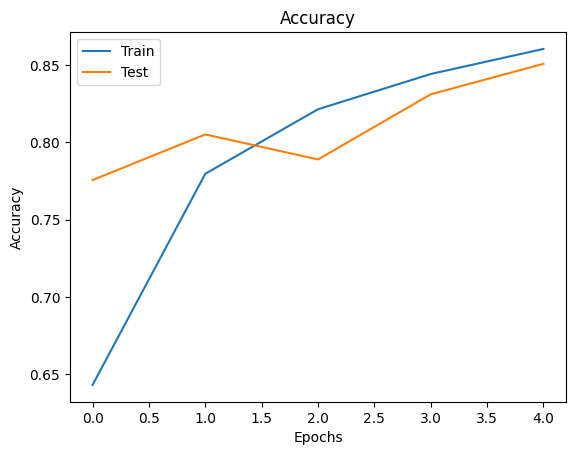

In [15]:
#Ілюстрація графіку залежності Accuracy від кількості епох
plt.figure()
plt.plot(history.history["accuracy"],label="Train");
plt.plot(history.history["val_accuracy"],label="Test");
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

Тепер побудуємо RNN з двома шарами LSTM

In [16]:
num_words = 15000  # Кількість слів у словнику
maxlen = 290  # Довжина послідовностей після pad_sequences

# Оновлений код з двома шарами LSTM
rnn_lstm = Sequential()

# Явне визначення вхідного шару
rnn_lstm.add(Input(shape=(maxlen,)))

# Шар Embedding
rnn_lstm.add(Embedding(input_dim=num_words, output_dim=32))

# Перший LSTM шар (передає послідовність в наступний шар)
rnn_lstm.add(LSTM(16, return_sequences=True, activation="relu"))

# Другий LSTM шар (повертає останній вектор)
rnn_lstm.add(LSTM(16, return_sequences=False, activation="relu"))

# Шар Dense
rnn_lstm.add(Dense(1))

# Шар активації
rnn_lstm.add(Activation("sigmoid"))

# Перегляд моделі
print(rnn_lstm.summary())

# Компіляція моделі
rnn_lstm.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 290, 32)             │         480,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 290, 16)             │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 485,265 (1.85 MB)

 Trainable params: 485,265 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

None


In [17]:
# Тренування моделі з LSTM
history = rnn_lstm.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 5,batch_size=128,verbose = 1)

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 61s 298ms/step - accuracy: 0.5190 - loss: 0.6921 - val_accuracy: 0.7120 - val_loss: 0.6227
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 87s 324ms/step - accuracy: 0.6057 - loss: 30.3236 - val_accuracy: 0.5607 - val_loss: 28.2848
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 59s 300ms/step - accuracy: 0.5605 - loss: 115.1822 - val_accuracy: 0.5608 - val_loss: 16.5048
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 81s 298ms/step - accuracy: 0.5640 - loss: 14.8820 - val_accuracy: 0.5455 - val_loss: 0.8724
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 82s 300ms/step - accuracy: 0.5388 - loss: 2.9226 - val_accuracy: 0.5495 - val_loss: 23.4001


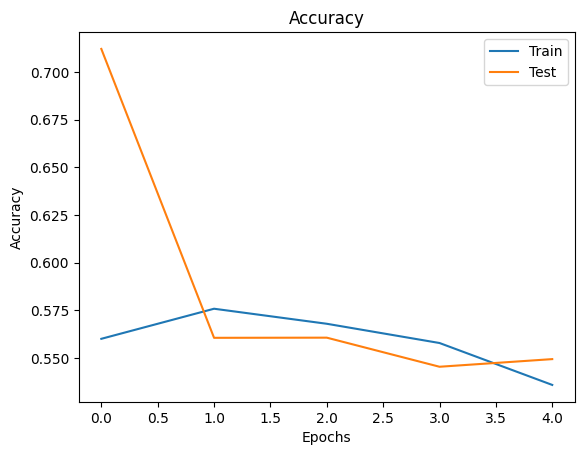

In [18]:
#Ілюстрація графіку залежності Accuracy від кількості епох
plt.figure()
plt.plot(history.history["accuracy"],label="Train");
plt.plot(history.history["val_accuracy"],label="Test");
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

Як бачимо, базова спроба на двошаровому LSTM не вийшла. З теорії вдалося з'ясувати, що функція ReLU не дуже підходить для активації на шарах LSTM, оскільки може призводити до "градієнтного вибуху", що значно погіршує тренування.

Графік ілюструє, що така модель не тренується взагалі.

Замінимо активаційну функцію на шарах LSTM на тангенс гіперболічний, який показує кращі результати, і перевіримо цю гіпотезу.

In [19]:

from keras.optimizers import RMSprop
#
num_words = 15000
maxlen = 290

# Модель
rnn_lstm = Sequential()
rnn_lstm.add(Input(shape=(maxlen,)))
rnn_lstm.add(Embedding(input_dim=num_words, output_dim=32))
rnn_lstm.add(LSTM(16, return_sequences=True, activation="tanh")) #Тепер tanh - активаційна функція на шарах LSTM
rnn_lstm.add(LSTM(16, return_sequences=False, activation="tanh"))
rnn_lstm.add(Dense(1, activation="sigmoid"))

# Компіляція
rnn_lstm.compile(loss="binary_crossentropy",
                 optimizer="rmsprop",
                 metrics=["accuracy"])

# Тренування
history = rnn_lstm.fit(X_train, Y_train,
                       validation_data=(X_test, Y_test),
                       epochs=5,
                       batch_size=128,
                       verbose=1)

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 62s 298ms/step - accuracy: 0.5634 - loss: 0.6658 - val_accuracy: 0.7974 - val_loss: 0.4670
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 58s 294ms/step - accuracy: 0.8292 - loss: 0.4110 - val_accuracy: 0.8339 - val_loss: 0.3786
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 82s 293ms/step - accuracy: 0.8725 - loss: 0.3236 - val_accuracy: 0.7846 - val_loss: 0.4966
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 84s 302ms/step - accuracy: 0.8934 - loss: 0.2774 - val_accuracy: 0.8575 - val_loss: 0.3328
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 82s 302ms/step - accuracy: 0.9065 - loss: 0.2409 - val_accuracy: 0.8827 - val_loss: 0.2910


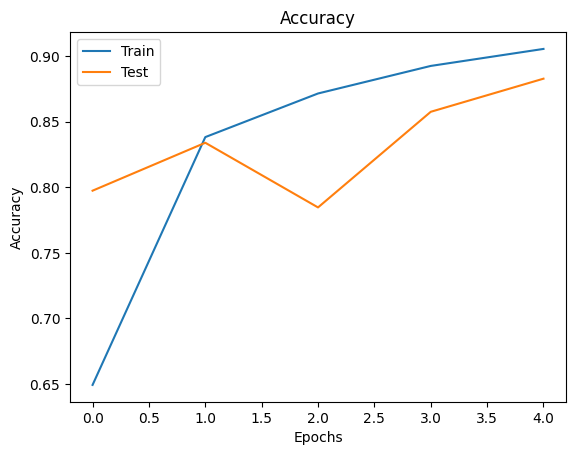

In [20]:
#Ілюстрація графіку залежності Accuracy від кількості епох
plt.figure()
plt.plot(history.history["accuracy"],label="Train");
plt.plot(history.history["val_accuracy"],label="Test");
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

Переконались, що використання тангенсу гіперболічного в якості активаційної функції на шарах LSTM виправило проблему - досягнули Accuracy у 0,88 за 5 епох

Ще перевіримо функцію активації за сігмоїдою

In [26]:
num_words = 15000
maxlen = 290

# Модель
rnn_lstm = Sequential()
rnn_lstm.add(Input(shape=(maxlen,)))
rnn_lstm.add(Embedding(input_dim=num_words, output_dim=32))
rnn_lstm.add(LSTM(16, return_sequences=True, activation="sigmoid"))
rnn_lstm.add(LSTM(16, return_sequences=False, activation="sigmoid"))
rnn_lstm.add(Dense(1, activation="sigmoid"))

# Компіляція
rnn_lstm.compile(loss="binary_crossentropy",
                 optimizer=RMSprop(learning_rate=0.001),
                 metrics=["accuracy"])

# Тренування
history = rnn_lstm.fit(X_train, Y_train,
                       validation_data=(X_test, Y_test),
                       epochs=5,
                       batch_size=128,
                       verbose=1)

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 68s 334ms/step - accuracy: 0.5070 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6946
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 76s 302ms/step - accuracy: 0.4959 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 90s 345ms/step - accuracy: 0.4977 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 76s 312ms/step - accuracy: 0.5130 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 58s 296ms/step - accuracy: 0.5083 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6930


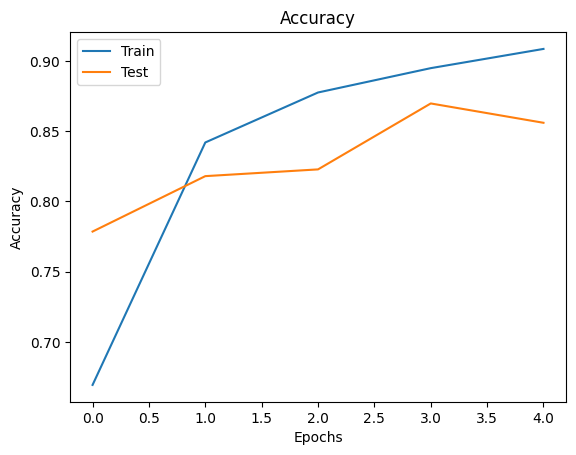

In [25]:
#Ілюстрація графіку залежності Accuracy від кількості епох
plt.figure()
plt.plot(history.history["accuracy"],label="Train");
plt.plot(history.history["val_accuracy"],label="Test");
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

Результати трохи гірші. Отже, визначили, що найкращі результати отримано за допомогою RNN на шарах LSTM з функцією тангенс гіперболічний як активаційною на шарах LSTM